<a href="https://colab.research.google.com/github/DattaIn/idatta.github.io/blob/master/Video_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives

At the end of the experiment, you will be able to :

* extract frames out of a video
* build the CNN model to extract features from the video frames
* train LSTM/GRU model to perform action classification

## Information

**Background:** The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.

CNN LSTMs were developed for visual time series prediction problems and the application of generating textual descriptions from sequences of images (e.g. videos). Specifically, the problems of:



*   Activity Recognition: Generating a textual description of an activity demonstrated in a sequence of images
*   Image Description: Generating a textual description of a single image.
*   Video Description: Generating a textual description of a sequence of images.

**Applications:** Applications such as surveillance, video retrieval and
human-computer interaction require methods for recognizing human actions in various scenarios. In the area of robotics, the tasks of
autonomous navigation or social interaction could also take advantage of the knowledge extracted
from live video recordings. Typical scenarios
include scenes with cluttered, moving backgrounds, nonstationary camera, scale variations, individual variations in
appearance and cloth of people, changes in light and view
point and so forth. All of these conditions introduce challenging problems that can be addressed using deep learning (computer vision) models.

## Dataset



**Dataset:** This dataset consists of labelled videos of 6 human actions (walking, jogging, running, boxing, hand waving and hand clapping) performed several times by 25 subjects in four different scenarios: outdoors s1, outdoors with scale variation s2, outdoors with different clothes s3 and indoors s4 as illustrated below.

![img](http://www.nada.kth.se/cvap/actions/actions.gif)

All sequences were taken over homogeneous backgrounds with a static camera with 25fps frame rate. The sequences were downsampled to the spatial resolution of 160x120 pixels and have a length of four seconds in average. In summary, there are 25x6x4=600 video files for each combination of 25 subjects, 6 actions and 4 scenarios. For this mini-project we have randomly selected 20% of the data as test set.

Dataset source: https://www.csc.kth.se/cvap/actions/

**Methodology:**

When performing image classification, we input an image to our CNN; Obtain the predictions from the CNN;
Choose the label with the largest corresponding probability


Since a video is just a series of image frames, in a video classification, we Loop over all frames in the video file;
For each frame, pass the frame through the CNN; Classify each frame individually and independently of each other; Choose the label with the largest corresponding probability;
Label the frame and write the output frame to disk

Refer this [Video Classification using Keras](https://medium.com/video-classification-using-keras-and-tensorflow/action-recognition-and-video-classification-using-keras-and-tensorflow-56badcbe5f77) for complete understanding and implementation example of video classification.

## Problem Statement

Train a CNN-LSTM based deep neural net to recognize the action being performed in a video

In [ ]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Actions.zip
!unzip -qq Actions.zip
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


### Import required packages

In [ ]:
import keras
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout
from keras.optimizers import Adam,Nadam

import os, glob
import cv2
import numpy as np

In [ ]:
from tensorflow import keras
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import imageio
from keras.preprocessing.image import ImageDataGenerator

### Load the data and generate frames of video (2 points)

Detecting an action is possible by analyzing a series of images (that we name “frames”) that are taken in time.

Hint: Refer data preparation section in [keras_video_classification](https://keras.io/examples/vision/video_classification/)


In [ ]:
path = "/content/Actions/"
dataset = {
    "video_path": [],
    "video_name": [],
    "tag": [],
    "sample_group": []
}

for where in os.listdir(path):
    #print(where) - test
    for class_name in os.listdir(path+"/"+where):
      for image in glob.glob(path+where+"/"+class_name+"/"+"*.avi"):
          #print(image.split('/')[-1])
          dataset["video_path"].append(image)
          dataset["video_name"].append(image.split('/')[-1])
          dataset["tag"].append(class_name)
          dataset["sample_group"].append(where)

In [ ]:
data = pd.DataFrame(dataset)
data.head()

,video_path,video_name,tag,sample_group
0,/content/Actions/test/running/person13_running...,person13_running_d1_uncomp.avi,running,test
1,/content/Actions/test/running/person04_running...,person04_running_d4_uncomp.avi,running,test
2,/content/Actions/test/running/person19_running...,person19_running_d1_uncomp.avi,running,test
3,/content/Actions/test/running/person10_running...,person10_running_d4_uncomp.avi,running,test
4,/content/Actions/test/running/person16_running...,person16_running_d2_uncomp.avi,running,test


In [ ]:
data['tag'].unique()

array(['running', 'jogging', 'boxing', 'Handclapping', 'Walking',
       'handwaving'], dtype=object)

In [ ]:
train_df = data[data['sample_group'] == 'train']
test_df  = data[data['sample_group'] == 'test']

In [ ]:
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 479
Total videos for testing: 120


In [ ]:
print("Count with Handclapping ", data[data.tag == 'Handclapping'].shape[0])
print("Count with Walking ", data[data.tag == 'Walking'].shape[0])
print("Count with boxing ", data[data.tag == 'boxing'].shape[0])
print("Count with handwaving ", data[data.tag == 'handwaving'].shape[0])
print("Count with jogging ", data[data.tag == 'jogging'].shape[0])
print("Count with running ", data[data.tag == 'running'].shape[0])

Count with Handclapping  99
Count with Walking  100
Count with boxing  100
Count with handwaving  100
Count with jogging  100
Count with running  100


In [ ]:
#Define Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
#pip install --upgrade keras keras-applications

     |████████████████████████████████| 50 kB 2.8 MB/s 


In [ ]:
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
# feature_extractor.output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'inception_v3')>

In [ ]:
label_processor = keras.layers.experimental.preprocessing.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df['tag']))
print(label_processor.get_vocabulary())

['', 'Handclapping', 'Walking', 'boxing', 'handwaving', 'jogging', 'running']


In [ ]:
sequence_model.save("sequence_model")

INFO:tensorflow:Assets written to: sequence_model/assets


INFO:tensorflow:Assets written to: sequence_model/assets


In [ ]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("sequence_model")

In [ ]:
pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-krclbhji
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-krclbhji
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0c60db3aa06bcd8030c684949373997ef2f03cdf8_-py3-none-any.whl size=154243 sha256=e67fb7f61cde8e32502f550e9c8db8ab1d0bedddcd44f60462a8237dcf84b42d
  Stored in directory: /tmp/pip-ephem-wheel-cache-h48bqnnn/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Failed to build tensorflow-docs
    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


#### Visualize the frames and analyze the object in each frame. (1 point)

* Plot the frames of each class per row (6 rows)
* Plot the title as label on each subplot

In [ ]:
random_list_per_class_frames = []
random_list_per_class_frames.append(np.random.choice(train_df[train_df.tag == 'Handclapping']["video_path"].values.tolist()))
random_list_per_class_frames.append(np.random.choice(train_df[train_df.tag == 'Walking']["video_path"].values.tolist()))
random_list_per_class_frames.append(np.random.choice(train_df[train_df.tag == 'boxing']["video_path"].values.tolist()))
random_list_per_class_frames.append(np.random.choice(train_df[train_df.tag == 'handwaving']["video_path"].values.tolist()))
random_list_per_class_frames.append(np.random.choice(train_df[train_df.tag == 'jogging']["video_path"].values.tolist()))
random_list_per_class_frames.append(np.random.choice(train_df[train_df.tag == 'running']["video_path"].values.tolist()))

len(random_list_per_class_frames)

6

In [ ]:
for path in random_list_per_class_frames:
  print(path)

/content/Actions/train/Handclapping/person06_handclapping_d2_uncomp.avi
/content/Actions/train/Walking/person13_walking_d4_uncomp.avi
/content/Actions/train/boxing/person10_boxing_d3_uncomp.avi
/content/Actions/train/handwaving/person17_handwaving_d2_uncomp.avi
/content/Actions/train/jogging/person14_jogging_d2_uncomp.avi
/content/Actions/train/running/person10_running_d1_uncomp.avi


In [ ]:
def to_gif_file(images, imagename):
    converted_images = images.astype(np.uint8)
    imageio.mimsave(imagename, converted_images, fps=10)
    return embed.embed_file(imagename)

In [ ]:
pip install keras-video-generators==1.0.11

  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.11-py3-none-any.whl size=12727 sha256=f3d8e46196a95fe4849a3b1c44c9efbe3039d08f7806438d7f0293d4d5ede4f9
  Stored in directory: /root/.cache/pip/wheels/6c/e2/54/eddd014b7cdf55aee3e086c16e2c75c6247d7b679f077fa864
Successfully built keras-video-generators
  Attempting uninstall: keras-video-generators
    Found existing installation: keras-video-generators 1.0.14
    Uninstalling keras-video-generators-1.0.14:
      Successfully uninstalled keras-video-generators-1.0.14


In [ ]:
type(label_processor.get_vocabulary())

In [ ]:
import keras_video
from keras_video import VideoFrameGenerator
# use sub directories names as classes
classes = label_processor.get_vocabulary() #[i.split(os.path.sep)[1] for i in glob.glob('videos/*')]
classes.sort()
# some global params
SIZE = (160, 120)
CHANNELS = 3
NBFRAME = 20
BS = 8
# pattern to get videos and classes
glob_pattern='/content/Actions/train/{classname}/*.avi'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes,
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split=.33,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

class , validation count: 0, train count: 0
class Handclapping, validation count: 26, train count: 53
class Walking, validation count: 26, train count: 54
class boxing, validation count: 26, train count: 54
class handwaving, validation count: 26, train count: 54
class jogging, validation count: 26, train count: 54
class running, validation count: 26, train count: 54
Total data: 7 classes for 323 files for train


In [ ]:
valid = train.get_validation_generator()

Total data: 7 classes for 156 files for validation


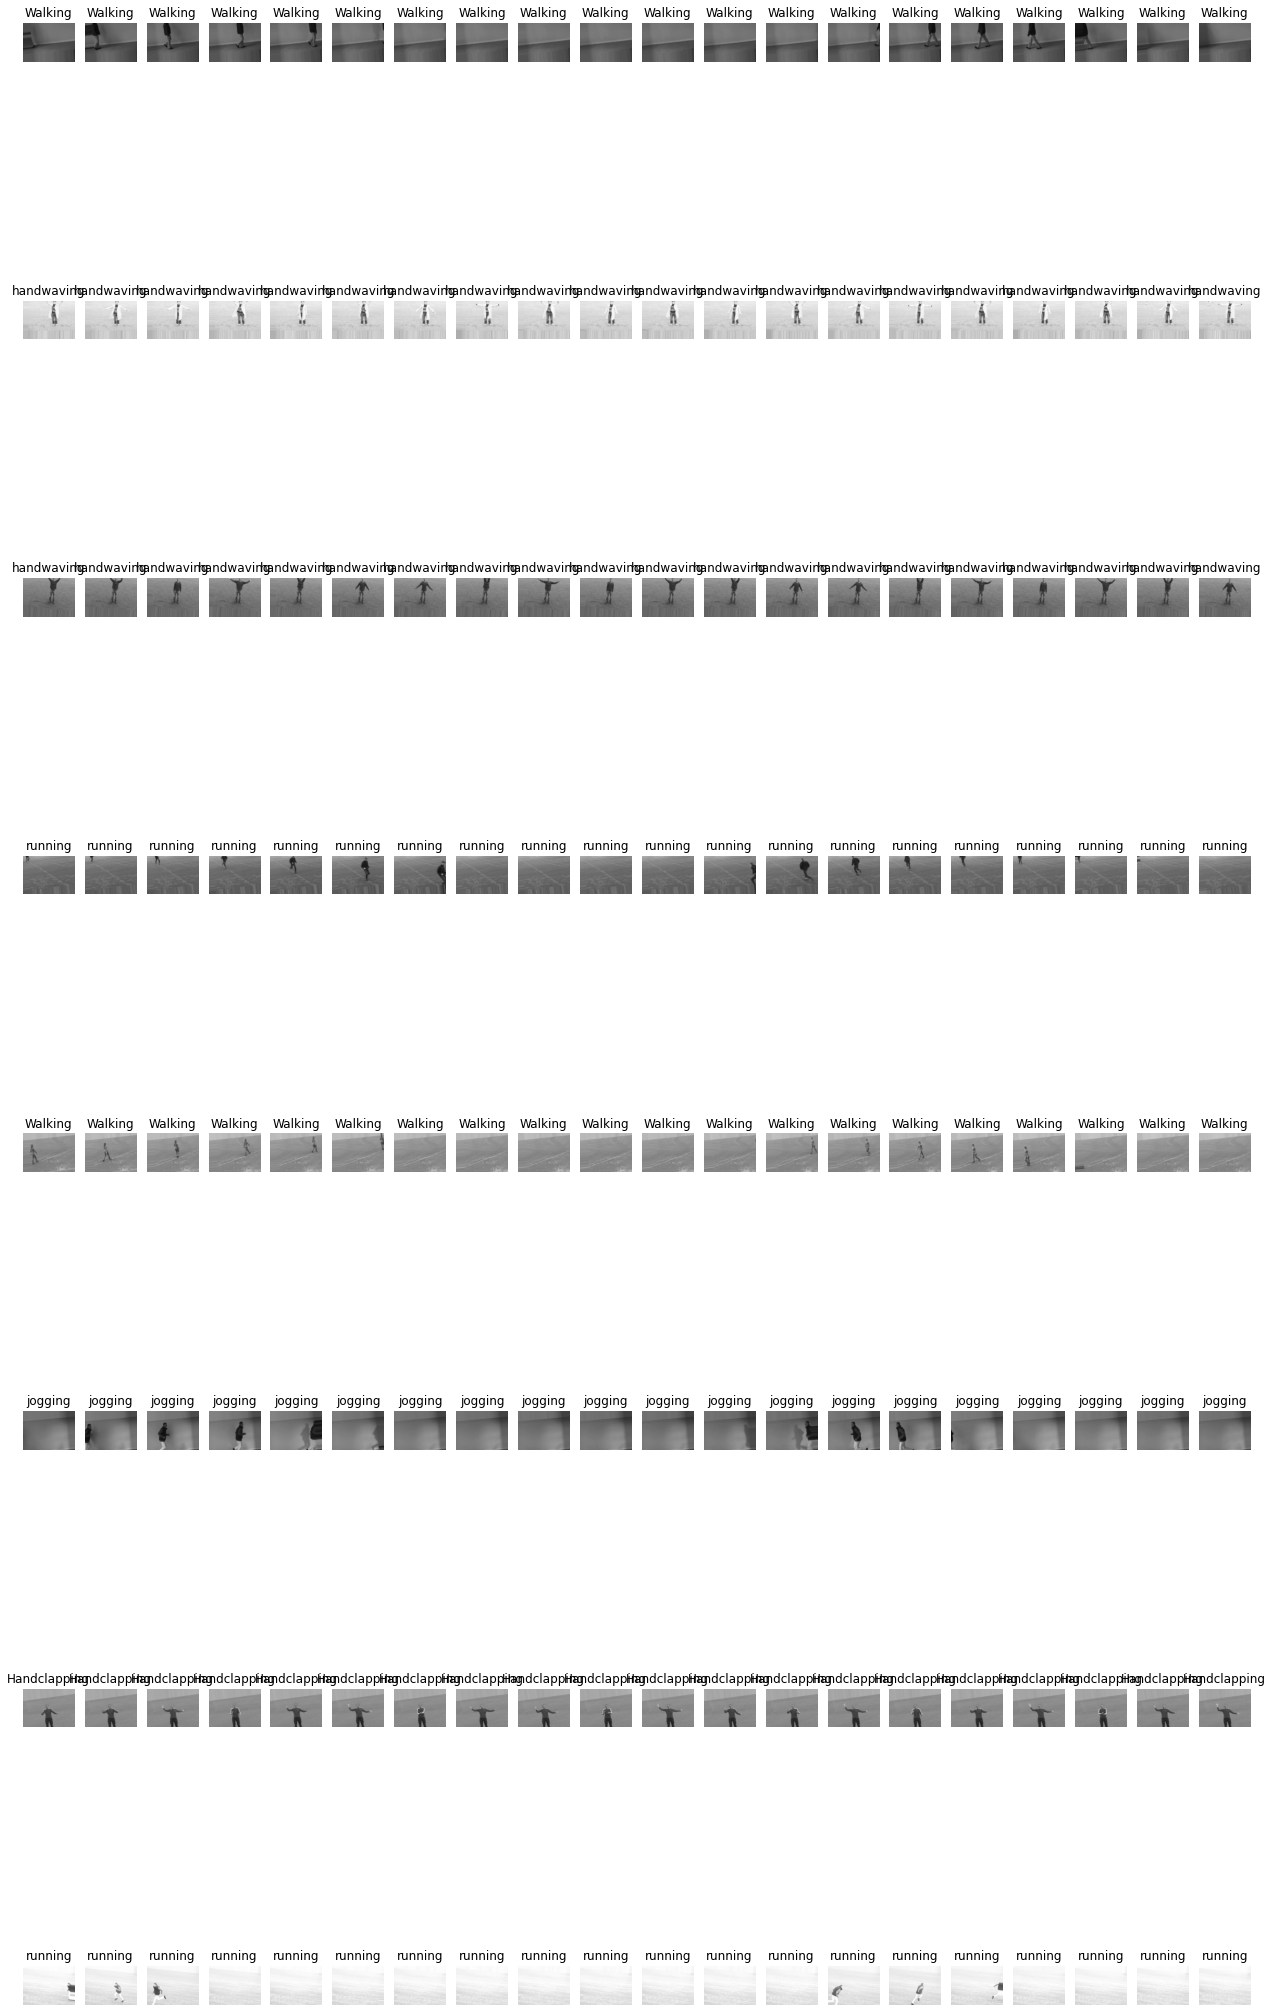

In [ ]:
import keras_video.utils
keras_video.utils.show_sample(train)

### Create the Neural Network (4 points)

We can build the model in several ways. We can use a well-known model that we inject in time distributed layer, or we can build our own.

With custom ConvNet each input image of the sequence must pass to a convolutional network. The goal is to train that model for each frame and then decide the class to infer.

* Use ConvNet and Time distributed to detect features.
* Inject the Time distributed output to GRU or LSTM to treat as a time series.
* Apply a DenseNet to take the decision and classify.

##### Build the ConvNet for the feature extraction, GRU LSTM layers as a time series and Dense layers for classification

In [ ]:
from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(160, 120, 3)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))

    model.add(MaxPool2D())

    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))

    model.add(MaxPool2D())

    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))

    model.add(MaxPool2D())

    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))

    # flatten...
    model.add(GlobalMaxPool2D())
    return model

In [ ]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout
def action_model(shape=(20, 160, 120, 3), nbout=3):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(shape[1:])

    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [ ]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)
print(INSHAPE)

(20, 160, 120, 3)


In [ ]:
# for example if you use seq_len = 20 (that means you want to analyze 20 frames)
# after you extract the frames for each video under train directory then your output should be similar to this
# ((479, 20, 160, 120, 3), (479,))
# 479 is number of videos in train directory
# 20 frames for each video
# (160, 120, 3) image dimension
# ***************
# this is for test directory
# (120, 20, 160, 120, 3)

# use label encoder to convert labels to one hot encoding
# (479, 6) is the shape for training

#(120, 6) for testing

#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

In [ ]:
EPOCHS=1
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]
model.fit_generator(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS
    #callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


     31/Unknown - 3518s 113s/step - loss: 2.0066 - acc: 0.1478

In [ ]:
# pattern to get videos and classes
glob_pattern_test='/content/Actions/test/{classname}/*.avi'
# Create video frame generator
test = VideoFrameGenerator(
    classes=classes,
    glob_pattern=glob_pattern_test,
    nb_frames=NBFRAME,
    split=.33,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

### Use pre-trained model for feature extraction (3 points)

To create a deep learning network for video classification:

* Convert videos to sequences of feature vectors using a pretrained convolutional neural network, such as VGG16, to extract features from each frame.

* Train an LSTM network on the sequences to predict the video labels.

* Assemble a network that classifies videos directly by combining layers from both networks.

Hint: [VGG-16 CNN and LSTM](https://riptutorial.com/keras/example/29812/vgg-16-cnn-and-lstm-for-video-classification)

In [ ]:
from keras import applications
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87916544/87910968 [==============================] - 2s 0us/step


In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_path"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_featutes = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[1]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_featutes[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_featutes.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (479, 20, 2048)
Frame masks in train set: (479, 20)


#### Load and fine-tune the pre-trained model

In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=1,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


history_pretrained, sequence_model = run_experiment()

11/11 [==============================] - 10s 313ms/step - loss: 1.8456 - accuracy: 0.2119 - val_loss: 2.3768 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.37677, saving model to /tmp/video_classifier
4/4 [==============================] - 0s 13ms/step - loss: 1.9339 - accuracy: 0.1417
Test accuracy: 14.17%


#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

Test video path: /content/Actions/test/Handclapping/person17_handclapping_d3_uncomp.avi
  running: 22.47%
  Handclapping: 22.05%
  jogging: 15.74%
  boxing: 13.71%
  Walking: 12.02%
  handwaving:  7.26%
  :  6.74%



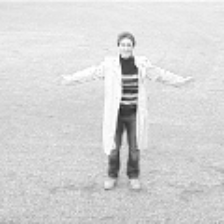

In [ ]:
from tensorflow_docs.vis import embed

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[1]

        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_featutes[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_featutes, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()
    #print(class_vocab)
    #print(os.path.join("test", path))
    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = reconstructed_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_path"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 9))
#performances = [history, history_vgg, history_resnet]
#models = ['My Model', 'VGG16', 'RESNET50']
performances = [history_pretrained, history_vgg]
models = ['My Model', 'VGG16']
def plot_model_performance(axs, performances):
  i = 0
  j = 0
  for history in performances:
    axs[i, j].plot(history.history['accuracy'])
    axs[i, j].plot(history.history['val_accuracy'])
    axs[i, j].set_title( models[i] + ' model accuracy')
    axs[i, j].set_ylabel('accuracy')
    axs[i, j].set_xlabel('epoch')
    axs[i, j].legend(['train', 'val'], loc='upper left')
    #axs[i, j].show()

    axs[i, j+1].plot(history.history['loss'])
    axs[i, j+1].plot(history.history['val_loss'])
    axs[i, j+1].set_title( models[i] + ' model loss')
    axs[i, j+1].set_ylabel('loss')
    axs[i, j+1].set_xlabel('epoch')
    axs[i, j+1].legend(['train', 'val'], loc='upper left')
    #axs[i, j+1].show()
    i = i + 1
    j = 0

plot_model_performance(axs, performances)
plt.tight_layout()
plt.show()

### Report Analysis

* Discuss on FPS, Number of frames and duration of each video
* Analyze the impact of the LSTM, GRU and TimeDistributed layers
* Discuss about the model convergence using pre-trained and ConvNet
* *Additional Reading*: Read and discuss about the use of Conv3D in video classification